In [1]:
import torch
from torch import nn
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.io import read_image
from torchvision import datasets
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
from torchvision import transforms as T
from torchvision.utils import save_image
from torchsummary import summary
from sklearn.preprocessing import MultiLabelBinarizer
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


(28, 56)
5 0


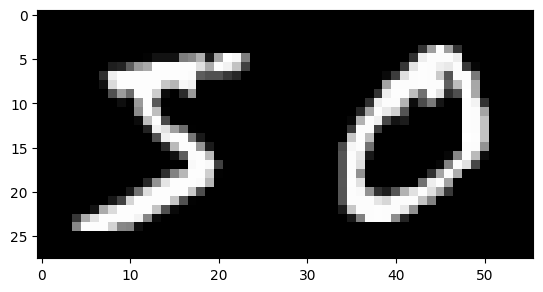

In [7]:
import struct

with open('aux/MNIST/raw/train-images-idx3-ubyte', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))
print(np.concatenate((data[0, :, :], data[1, :, :]), axis=1).shape)
plt.imshow(np.concatenate((data[0, :, :], data[1, :, :]), axis=1), cmap='gray')

with open('aux/MNIST/raw/train-labels-idx1-ubyte', 'rb') as l:
    magic, size = struct.unpack(">II", l.read(8))
    lbls = np.fromfile(l, dtype=np.dtype(np.uint8).newbyteorder('>'))
    lbls = lbls.reshape((size,))  # (Optional)
print(lbls[0], lbls[1])


In [8]:
train_numbers = []
train_labels = []
for i in range(lbls.shape[0]-1):
    number = np.concatenate((data[i, :, :], data[i+1, :, :]), axis=1)
    label = (lbls[i], lbls[i + 1])
    train_numbers.append(number)
    train_labels.append(label)
print(np.array(train_numbers).shape)
print(np.array(train_labels).shape)


(59999, 28, 56)
(59999, 2)


(28, 56)
7 2


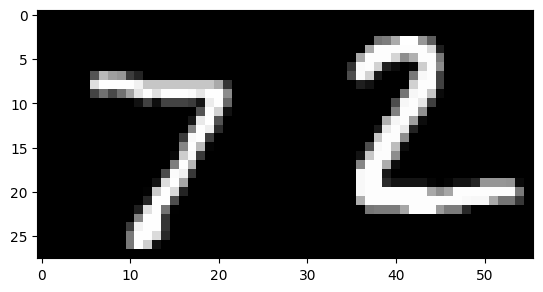

In [9]:
with open('aux/MNIST/raw/t10k-images-idx3-ubyte', 'rb') as f:
    magic, size = struct.unpack(">II", f.read(8))
    nrows, ncols = struct.unpack(">II", f.read(8))
    data = np.fromfile(f, dtype=np.dtype(np.uint8).newbyteorder('>'))
    data = data.reshape((size, nrows, ncols))
print(np.concatenate((data[0, :, :], data[1, :, :]), axis=1).shape)
plt.imshow(np.concatenate((data[0, :, :], data[1, :, :]), axis=1), cmap='gray')

with open('aux/MNIST/raw/t10k-labels-idx1-ubyte', 'rb') as l:
    magic, size = struct.unpack(">II", l.read(8))
    lbls = np.fromfile(l, dtype=np.dtype(np.uint8).newbyteorder('>'))
    lbls = lbls.reshape((size,))  # (Optional)
print(lbls[0], lbls[1])


In [10]:
valid_numbers = []
valid_labels = []
for i in range(lbls.shape[0]-1):
    number = np.concatenate((data[i, :, :], data[i+1, :, :]), axis=1)
    label = (lbls[i], lbls[i + 1])
    valid_numbers.append(number)
    valid_labels.append(label)
print(np.array(valid_numbers).shape)
print(np.array(valid_labels).shape)


(9999, 28, 56)
(9999, 2)


In [11]:
mlb = MultiLabelBinarizer()
train_labels = mlb.fit_transform(train_labels)
valid_labels = mlb.fit_transform(valid_labels)


In [12]:
class NumbersDataset(Dataset):
    def __init__(self, labels, images):
        self.labels = labels
        self.images = images

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = torch.tensor(self.images[idx])
        label = torch.tensor(self.labels[idx])
        return torch.unsqueeze(image, dim=0)/255, label.float()


train_data = NumbersDataset(train_labels, train_numbers)
valid_data = NumbersDataset(valid_labels, valid_numbers)


In [13]:
valid_data.__getitem__(0)


(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([0., 0., 1., 0., 0., 0., 0., 1., 0., 0.]))

In [14]:
train_loader = DataLoader(
    train_data,
    batch_size=64, shuffle=True
)
valid_loader = DataLoader(
    valid_data,
    batch_size=64, shuffle=True
)


tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 1.])


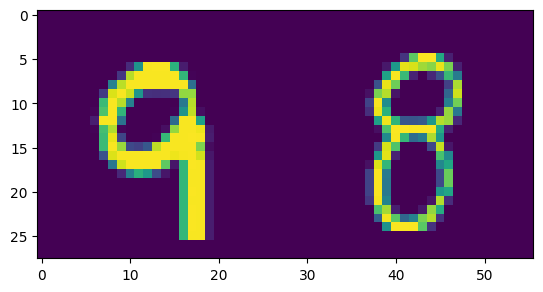

In [15]:
for images, labels in train_loader:
    for im in images:
        # print(im)
        # im =im
        plt.imshow(im[0])
        # plt.imshow(torch.permute(im,(1,2,0)))
        # label = i[1]
        # print(label)
        break
    for l in labels:
        print(l)
        break
    break


In [19]:
class MLClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2)
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.linear = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3136, 1600),
            nn.Dropout(),
            nn.ReLU(),
            nn.Linear(1600, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool(x)
        x = self.conv3(x)
        x = self.pool(x)
        x = self.linear(x)
        return x


In [20]:
model = MLClassifier()
summary(model, (1, 28, 56))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 56]              80
              ReLU-2            [-1, 8, 28, 56]               0
            Conv2d-3           [-1, 16, 28, 56]           1,168
              ReLU-4           [-1, 16, 28, 56]               0
         MaxPool2d-5           [-1, 16, 14, 28]               0
            Conv2d-6           [-1, 32, 14, 28]           4,640
              ReLU-7           [-1, 32, 14, 28]               0
         MaxPool2d-8            [-1, 32, 7, 14]               0
           Flatten-9                 [-1, 3136]               0
           Linear-10                 [-1, 1600]       5,019,200
          Dropout-11                 [-1, 1600]               0
             ReLU-12                 [-1, 1600]               0
           Linear-13                   [-1, 10]          16,010
          Sigmoid-14                   

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)


MLClassifier(
  (conv1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (linear): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=1600, bias=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): ReLU()
    (4): Linear(in_features=1600, out_features=10, bias=True)
    (5): Sigmoid()
  )
)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

In [23]:
epoch_losses_train = []
epoch_losses_valid = []

for epoch in tqdm(np.arange(10)):
    batch_losses = []
    model.train()
    for numbers, labels in train_loader:
        pred = model(numbers.to(device))
        optimizer.zero_grad()
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()
        batch_losses.append(loss.item())

    epoch_losses_train.append(np.mean(batch_losses))

    batch_losses = []
    model.eval()
    for numbers, labels in valid_loader:
        pred = model(numbers.to(device))
        loss = criterion(pred, labels)
        batch_losses.append(loss.item())
    epoch_losses_valid.append(np.mean(batch_losses))

    print(
        f'Epoch {epoch} train_loss: {epoch_losses_train[-1]:.4f}, valid: {epoch_losses_valid[-1]:.4f}')


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 0 train_loss: 0.1976, valid: 0.0569
Epoch 1 train_loss: 0.0788, valid: 0.0415
Epoch 2 train_loss: 0.0660, valid: 0.0358
Epoch 3 train_loss: 0.0617, valid: 0.0343
Epoch 4 train_loss: 0.0591, valid: 0.0334
Epoch 5 train_loss: 0.0567, valid: 0.0362
Epoch 6 train_loss: 0.0566, valid: 0.0345
Epoch 7 train_loss: 0.0555, valid: 0.0330
Epoch 8 train_loss: 0.0538, valid: 0.0360
Epoch 9 train_loss: 0.0527, valid: 0.0384


In [24]:
def plot_loss_metrics(tl: list, vl: list):

    plt.plot(tl, label='Train loss')
    plt.plot(vl, label='Valid Loss')
    plt.legend()

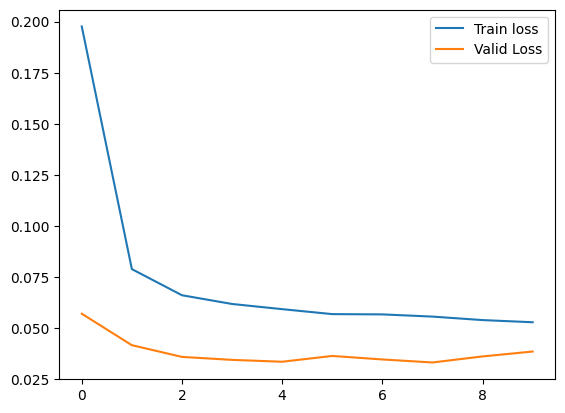

In [25]:
plot_loss_metrics(epoch_losses_train, epoch_losses_valid)

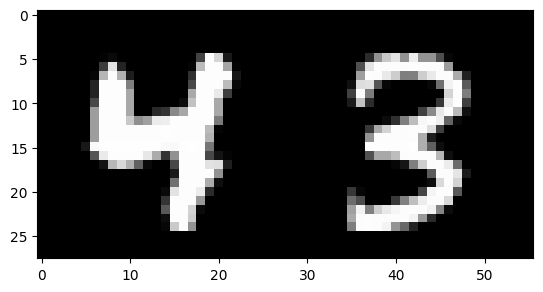

In [26]:
im = np.concatenate((data[85, :, :], data[9429, :, :]), axis=1)
plt.imshow(im, cmap='gray')


In [28]:
dummy_input = torch.randn(1, 1, 28, 56).to(device)
torch.onnx.export(model, dummy_input, 'model/numbers.onnx',
                  input_names=['data'], output_names=['output'],
                  export_params=True)


In [29]:
im = torch.tensor(im)/255
save_image(im, 'images/test.jpg')

In [30]:
import onnxruntime
from onnxruntime import InferenceSession
import json

onnx_model = 'model/numbers.onnx'

img = read_image('images/test.jpg')
transform = T.transforms.Grayscale()
img = transform(img)
img = img.clone().detach()
img = torch.unsqueeze(img, 0)/255
# img[...,:3]
# img = np.dot(img[...,:3], [0, 0.587, 0.114])
# img
# img.resize((1, 1, 28, 56))
img.shape
data = json.dumps({'data': img.tolist()})
data = np.array(json.loads(data)['data']).astype('float32')


In [31]:
session = onnxruntime.InferenceSession(onnx_model, None)
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name
# print(input_name)
# print(output_name)


In [32]:
result = session.run([output_name], {input_name: data})
print(result)

max_indices = np.argsort(np.array(result).squeeze())[-2:][::-1]
prediction = "".join(map(lambda x: str(x), max_indices.tolist()))
print(prediction)


[array([[ 3.2782555e-07,  3.6045909e-04,  3.2573938e-03,  9.9999982e-01,
         9.9999905e-01,  1.1920929e-07, -5.9604645e-08,  3.3025742e-03,
         5.8889389e-05,  6.3896179e-04]], dtype=float32)]
34
